
>>> Starting Variance Experiment (Samples per point: 50)
----------------------------------------------------------------------
N=4, Depth=4 | Var(Orig): 2.9215e-01 | Var(MPQC): 3.5645e-02
N=5, Depth=5 | Var(Orig): 1.3354e-01 | Var(MPQC): 2.7539e-02
N=6, Depth=6 | Var(Orig): 9.5025e-02 | Var(MPQC): 2.0935e-02
N=7, Depth=7 | Var(Orig): 5.1956e-02 | Var(MPQC): 1.6803e-02
N=8, Depth=8 | Var(Orig): 3.2835e-02 | Var(MPQC): 1.1284e-02
N=9, Depth=9 | Var(Orig): 1.6127e-02 | Var(MPQC): 4.2097e-03
N=10, Depth=10 | Var(Orig): 9.7301e-03 | Var(MPQC): 4.9418e-03


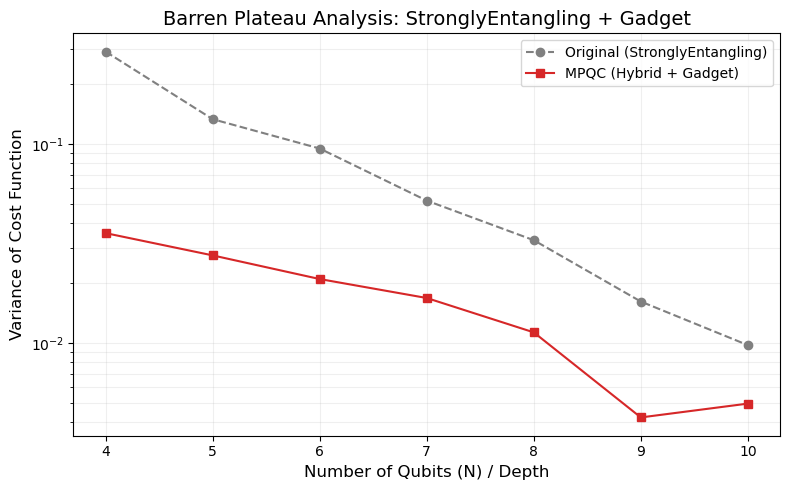

In [3]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. Circuit Layer Definitions
# =============================================================================

def MPQC_Layer(wires, params):
    """
    Represents one 'Block' of the variational circuit.
    
    According to your request, this is now a single layer of 
    StronglyEntanglingLayers.
    
    Args:
        wires: The wires to apply the layer on.
        params: A flat array of parameters. 
                Expected size: len(wires) * 3.
    """
    n_wires = len(wires)

    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3).
    # Here we apply 1 layer per block.
    reshaped_params = params.reshape((1, n_wires, 3))

    # We use 'ranges=[1]' to simulate nearest-neighbor entanglement 
    # similar to the previous architecture, or leave default. 
    # Standard StronglyEntangling uses ranges=[1] for 1 layer usually.
    qml.StronglyEntanglingLayers(reshaped_params, wires=wires)


# =============================================================================
# 2. Gadget Layer Definitions
#    (Unchanged from previous version)
# =============================================================================

def apply_U(wire, phi, psi):
    """Helper gate U applied to Ancilla qubits."""
    qml.RZ(phi, wires=wire)
    qml.RY(2 * psi, wires=wire)

def Gadget_Layer(data_wires, anc_wires, interaction_params, u_params):
    """
    Applies the Gadget Layer:
    1. U(phi, psi) on Ancilla.
    2. Ising XX, YY, ZZ coupling between Ancilla and Data qubits.
    """
    phi, psi = u_params[0], u_params[1]

    for i in range(len(data_wires)):
        d_wire = data_wires[i]
        a_wire = anc_wires[i]

        # Apply U on Ancilla
        apply_U(a_wire, phi, psi)

        # Apply Interaction (Ancilla <-> Data)
        # interaction_params[i] contains [theta_xx, theta_yy, theta_zz]
        qml.IsingXX(interaction_params[i, 0], wires=[a_wire, d_wire])
        qml.IsingYY(interaction_params[i, 1], wires=[a_wire, d_wire])
        qml.IsingZZ(interaction_params[i, 2], wires=[a_wire, d_wire])

def get_mpqc_param_count(n_qubits, depth):
    """
    Calculates the total parameters for the MPQC blocks.
    StronglyEntanglingLayers (1 layer) needs N * 3 parameters.
    Total = Depth * N * 3.
    """
    return depth * n_qubits * 3

# =============================================================================
# 3. Dynamic Circuit Builders
# =============================================================================

def get_cost_functions(n_data):
    """
    Returns two QNodes for a specific number of data qubits (N):
    1. circuit_orig: Original PQC (No Gadget).
    2. circuit_mpqc: Hybrid PQC (With Gadget inserted before the last block).
    
    Constraint: Depth = n_data.
    """
    depth = n_data

    # --- 1. Original Circuit (No Gadget) ---
    dev_orig = qml.device("default.qubit", wires=n_data)

    @qml.qnode(dev_orig)
    def circuit_no_gadget(params):
        wires = range(n_data)
        cursor = 0

        # Each layer in the loop is one MPQC_Layer (StronglyEntangling)
        for d in range(depth):

            # Calculate parameters needed for this layer (N * 3)
            n_layer_params = n_data * 3

            # Slice parameters
            layer_params = params[cursor : cursor + n_layer_params]

            # Apply Layer
            MPQC_Layer(wires, layer_params)

            cursor += n_layer_params

        # Measurement: Sum of PauliZ on all wires
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_data)]))

    # --- 2. Hybrid MPQC Circuit (With Gadget) ---
    # Requires 2*N wires (Data + Ancilla)
    n_total = 2 * n_data
    dev_mpqc = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev_mpqc)
    def circuit_with_gadget(mpqc_params, gadget_params, u_params):
        data_wires = list(range(n_data))
        anc_wires = list(range(n_data, n_total))

        cursor = 0

        for d in range(depth):
            # === Insert Gadget before the LAST block ===
            if d == depth - 1:
                # Visual barrier
                qml.Barrier(wires=range(n_total))

                # Apply Gadget
                reshaped_gadget = gadget_params.reshape((n_data, 3))
                Gadget_Layer(data_wires, anc_wires, reshaped_gadget, u_params)

                # Visual barrier
                qml.Barrier(wires=range(n_total))

            # === Standard MPQC Block (StronglyEntangling) ===
            n_layer_params = n_data * 3
            layer_params = mpqc_params[cursor : cursor + n_layer_params]

            # Note: MPQC_Layer applies only to Data Wires
            MPQC_Layer(data_wires, layer_params)

            cursor += n_layer_params

        # Measurement: Sum of PauliZ on Data wires only
        return qml.expval(qml.sum(*[qml.PauliZ(i) for i in data_wires]))

    return circuit_no_gadget, circuit_with_gadget

# =============================================================================
# 4. Experiment Runner (Variance Calculation)
# =============================================================================

def run_variance_experiment(n_qubit_list, n_samples=100):
    """
    Runs the sampling experiment to calculate Var(Cost) for different N.
    """
    var_orig_list = []
    var_mpqc_list = []

    print(f"\n>>> Starting Variance Experiment (Samples per point: {n_samples})")
    print("-" * 70)

    for n in n_qubit_list:
        depth = n

        # Get QNodes for current N
        circuit_orig, circuit_mpqc = get_cost_functions(n)

        # Calculate required parameter counts
        n_mpqc_params = get_mpqc_param_count(n, depth)
        n_gadget_params = n * 3
        n_u_params = 2

        # --- Sampling Original Circuit ---
        losses_orig = []
        for _ in range(n_samples):
            # Random parameters [0, 2pi]
            theta = 2 * np.pi * np.random.rand(n_mpqc_params)
            val = circuit_orig(theta)
            losses_orig.append(val)

        # --- Sampling MPQC Circuit (Hybrid) ---
        losses_mpqc = []
        for _ in range(n_samples):
            theta_m = 2 * np.pi * np.random.rand(n_mpqc_params)
            theta_g = 2 * np.pi * np.random.rand(n_gadget_params)
            theta_u = 2 * np.pi * np.random.rand(n_u_params)
            val = circuit_mpqc(theta_m, theta_g, theta_u)
            losses_mpqc.append(val)

        # Calculate Variances
        v_orig = np.var(losses_orig)
        v_mpqc = np.var(losses_mpqc)

        var_orig_list.append(v_orig)
        var_mpqc_list.append(v_mpqc)

        print(f"N={n}, Depth={depth} | Var(Orig): {v_orig:.4e} | Var(MPQC): {v_mpqc:.4e}")

    return var_orig_list, var_mpqc_list

# =============================================================================
# 5. Plotting Helper
# =============================================================================

def plot_results(n_qubit_list, var_orig, var_mpqc):
    plt.figure(figsize=(8, 5))

    plt.plot(n_qubit_list, var_orig, 'o--', color='grey', label="Original (StronglyEntangling)")
    plt.plot(n_qubit_list, var_mpqc, 's-', color='#d62728', label="MPQC (Hybrid + Gadget)")

    plt.xlabel("Number of Qubits (N) / Depth", fontsize=12)
    plt.ylabel("Variance of Cost Function", fontsize=12)
    plt.yscale("log") # Log scale is crucial for Barren Plateau analysis
    plt.title("Barren Plateau Analysis: StronglyEntangling + Gadget", fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    filename = "variance_scaling_strong_ent.png"
    plt.tight_layout()
    # plt.savefig(filename, dpi=300)
    # print(f"\n>>> Result plot saved as '{filename}'")
    plt.show()

# =============================================================================
# 6. Main Execution
# =============================================================================

if __name__ == "__main__":
    N_LIST = [4,5,6,7,8,9,10]

    # Run experiment
    v_orig, v_mpqc = run_variance_experiment(N_LIST, n_samples=50)

    # Plot results
    plot_results(N_LIST, v_orig, v_mpqc)

>>> Generating circuit diagrams for N=4, Depth=4...

[1/2] Drawing Original Circuit...


/var/folders/11/3v4yjwwj59gc60lpr8h0kh780000gn/T/ipykernel_56332/3541728131.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


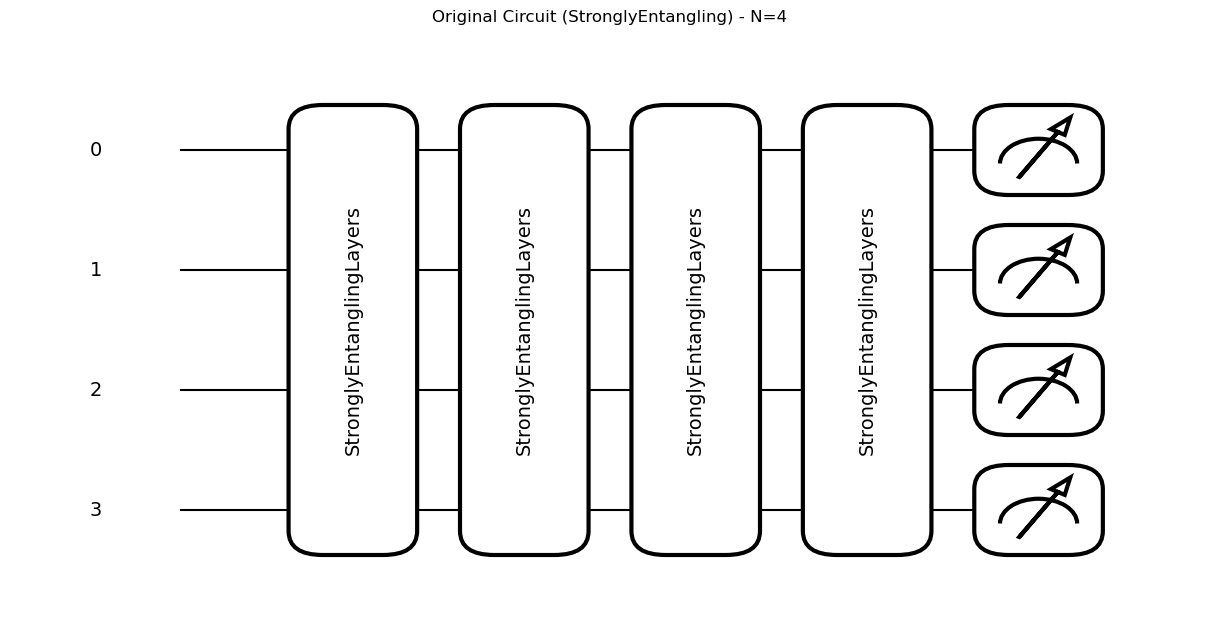


[2/2] Drawing Hybrid Circuit...


/var/folders/11/3v4yjwwj59gc60lpr8h0kh780000gn/T/ipykernel_56332/3541728131.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


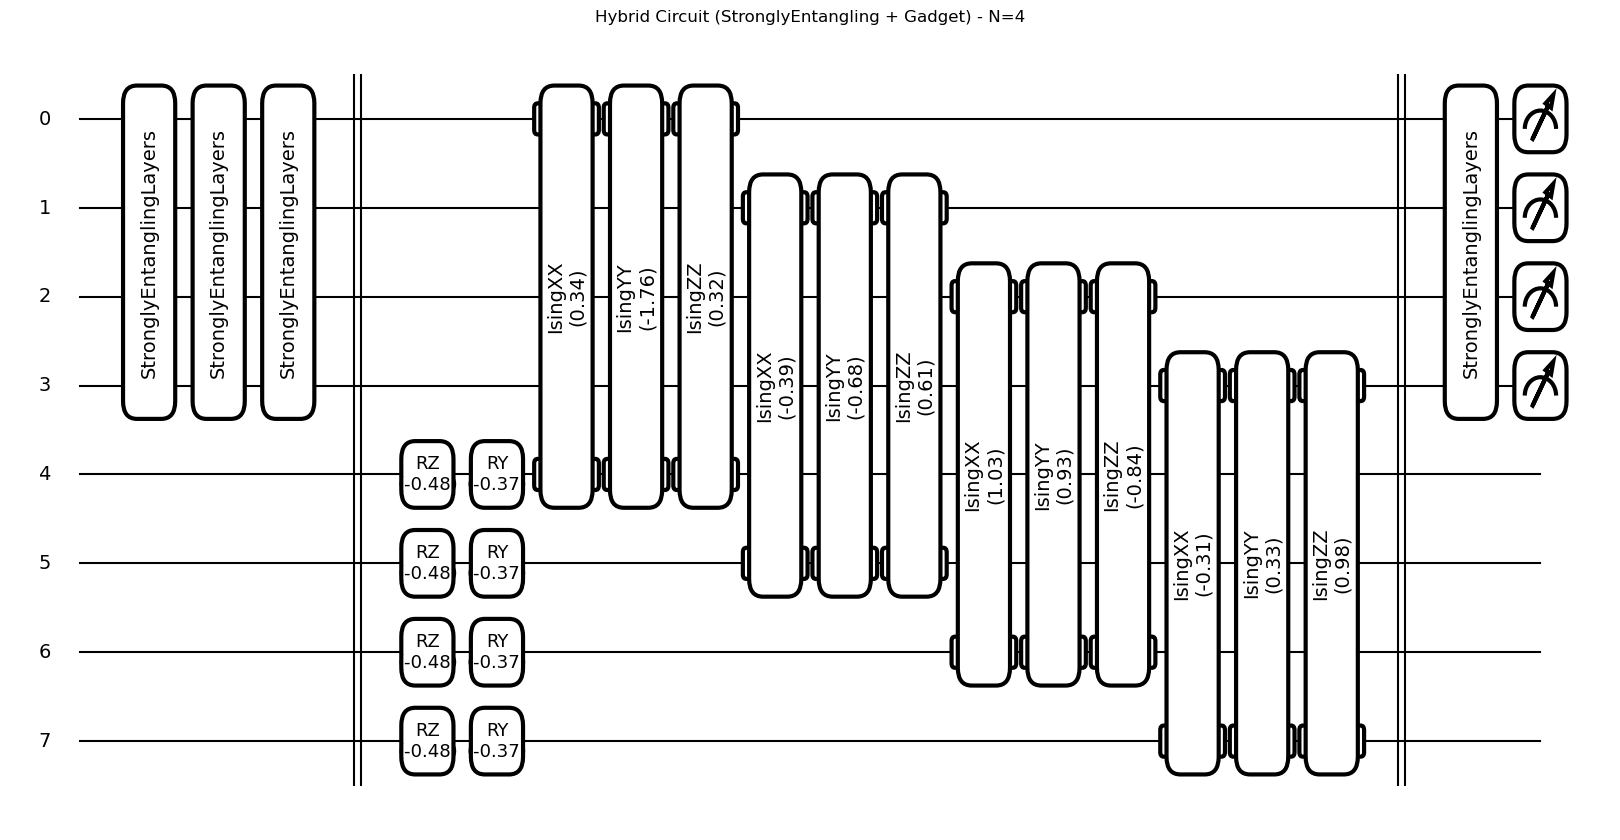

In [3]:
# =============================================================================
# Visualization Block
# (Assumes previous function definitions are loaded)
# =============================================================================

# 1. Configuration for visualization
# We use N=4 to make the diagram readable.
N_vis = 4
Depth_vis = 4

print(f">>> Generating circuit diagrams for N={N_vis}, Depth={Depth_vis}...")

# 2. Instantiate the specific QNodes for N=4
# circ_orig: The circuit without the gadget layer
# circ_mpqc: The circuit with the gadget layer inserted
circ_orig, circ_mpqc = get_cost_functions(N_vis)

# 3. Generate dummy parameters matching the required shapes
n_mpqc_p = get_mpqc_param_count(N_vis, Depth_vis)  # Params for StronglyEntangling
n_gadg_p = N_vis * 3                               # Params for Ising coupling
n_u_p = 2                                          # Params for U gate (phi, psi)

np.random.seed(42)
theta_m = np.random.randn(n_mpqc_p)
theta_g = np.random.randn(n_gadg_p)
theta_u = np.random.randn(n_u_p)

# -----------------------------------------------------------------------------
# 4. Draw Circuit 1: Original (StronglyEntangling Only)
# -----------------------------------------------------------------------------
print("\n[1/2] Drawing Original Circuit...")
try:
    # qml.draw_mpl returns a function that generates the figure
    fig1, ax1 = qml.draw_mpl(circ_orig, decimals=2)(theta_m)

    # Adjust figure size for better visibility
    fig1.set_size_inches(12, 6)
    plt.title(f"Original Circuit (StronglyEntangling) - N={N_vis}")

    # Save and Display
    plt.tight_layout()
    # save_name1 = "circuit_original_se.png"
    # fig1.savefig(save_name1, dpi=300, bbox_inches="tight")
    # print(f"Successfully saved: {save_name1}")
    plt.show()

except Exception as e:
    print(f"Error drawing Original Circuit: {e}")

# -----------------------------------------------------------------------------
# 5. Draw Circuit 2: Hybrid (StronglyEntangling + Gadget)
# -----------------------------------------------------------------------------
print("\n[2/2] Drawing Hybrid Circuit...")
try:
    # This circuit takes 3 sets of parameters
    fig2, ax2 = qml.draw_mpl(circ_mpqc, decimals=2)(theta_m, theta_g, theta_u)

    # Adjust figure size (Hybrid circuit is larger due to Ancilla wires)
    fig2.set_size_inches(16, 8)
    plt.title(f"Hybrid Circuit (StronglyEntangling + Gadget) - N={N_vis}")

    # Save and Display
    plt.tight_layout()
    # save_name2 = "circuit_hybrid_se.png"
    # fig2.savefig(save_name2, dpi=300, bbox_inches="tight")
    # print(f"Successfully saved: {save_name2}")
    plt.show()

except Exception as e:
    print(f"Error drawing Hybrid Circuit: {e}")